# TASK3 特征工程

# 3.1 任务目标

# 3.2 内容介绍

代码如下：

导入需要的库

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

读取数据

In [2]:
traindata=pd.read_csv('F:\二手车\car_train_0110.csv',sep=' ')
testdata=pd.read_csv('F:\二手车\car_testA_0110.csv',sep=' ')

In [3]:
traindata.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_14,v_15,v_16,v_17,v_18,v_19,v_20,v_21,v_22,v_23
0,134890,734,20160002,13.0,9,NaN,0.0,1.0,0,15.0,...,0.092139,0.000000,18.763832,-1.512063,-1.008718,-12.100623,-0.947052,9.077297,0.581214,3.945923
1,306648,196973,20080307,72.0,9,7.0,5.0,1.0,173,15.0,...,0.001070,0.122335,-5.685612,-0.489963,-2.223693,-0.226865,-0.658246,-3.949621,4.593618,-1.145653
2,340675,25347,20020312,18.0,12,3.0,0.0,1.0,50,12.5,...,0.064410,0.003345,-3.295700,1.816499,3.554439,-0.683675,0.971495,2.625318,-0.851922,-1.246135
3,57332,5382,20000611,38.0,8,7.0,0.0,1.0,54,15.0,...,0.069231,0.000000,-3.405521,1.497826,4.782636,0.039101,1.227646,3.040629,-0.801854,-1.251894
4,265235,173174,20030109,87.0,0,5.0,5.0,1.0,131,3.0,...,0.000099,0.001655,-4.475429,0.124138,1.364567,-0.319848,-1.131568,-3.303424,-1.998466,-1.279368


In [4]:
testdata.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_14,v_15,v_16,v_17,v_18,v_19,v_20,v_21,v_22,v_23
0,720326,505,20060505,19.0,13,7.0,0.0,1.0,90,8.0,...,0.083340,0.105382,-5.998993,0.147048,-1.902847,0.348990,2.324961,3.343910,4.048742,-1.431822
1,714316,1836,20010301,5.0,5,3.0,4.0,1.0,75,15.0,...,0.074478,0.000000,-3.287221,2.081317,2.937052,-0.123018,1.202395,3.570743,-1.180587,-1.348598
2,704693,212291,20170610,6.0,18,NaN,5.0,0.0,150,15.0,...,0.002032,0.000000,4.368218,8.252188,-4.136109,-13.334970,-4.444620,-0.706978,-1.720218,3.569112
3,624972,1345,19820005,215.0,32,7.0,0.0,1.0,0,6.0,...,0.098806,0.100883,-2.537486,0.513955,4.414962,0.357685,2.700732,5.323602,6.085956,-0.900585
4,669753,1428,20060205,30.0,4,7.0,5.0,1.0,122,15.0,...,0.088397,0.002509,-6.197633,-0.191814,-1.224360,-0.326985,2.254931,4.183037,-2.574004,0.014203


异常处理函数

In [5]:
def outliers_proc(data, col_name, scale=3):
    """
    用于清洗异常值，默认用 box_plot（scale=3）进行清洗
    :param data: 接收 pandas 数据格式
    :param col_name: pandas 列名
    :param scale: 尺度
    :return:
    """

    def box_plot_outliers(data_ser, box_scale):
        """
        利用箱线图去除异常值
        :param data_ser: 接收 pandas.Series 数据格式
        :param box_scale: 箱线图尺度，
        :return:
        """
        iqr = box_scale * (data_ser.quantile(0.75) - data_ser.quantile(0.25))
        val_low = data_ser.quantile(0.25) - iqr
        val_up = data_ser.quantile(0.75) + iqr
        rule_low = (data_ser < val_low)
        rule_up = (data_ser > val_up)
        return (rule_low, rule_up), (val_low, val_up)

    data_n = data.copy()
    data_series = data_n[col_name]
    rule, value = box_plot_outliers(data_series, box_scale=scale)
    index = np.arange(data_series.shape[0])[rule[0] | rule[1]]
    print("Delete number is: {}".format(len(index)))
    data_n = data_n.drop(index)
    data_n.reset_index(drop=True, inplace=True)
    print("Now column number is: {}".format(data_n.shape[0]))
    index_low = np.arange(data_series.shape[0])[rule[0]]
    outliers = data_series.iloc[index_low]
    print("Description of data less than the lower bound is:")
    print(pd.Series(outliers).describe())
    index_up = np.arange(data_series.shape[0])[rule[1]]
    outliers = data_series.iloc[index_up]
    print("Description of data larger than the upper bound is:")
    print(pd.Series(outliers).describe())
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 7))
    sns.boxplot(y=data[col_name], data=data, palette="Set1", ax=ax[0])
    sns.boxplot(y=data_n[col_name], data=data_n, palette="Set1", ax=ax[1])
    return data_n

这里我选择剔除价格和发动机功率异常的数据

Delete number is: 6423
Now column number is: 243577
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: price, dtype: float64
Description of data larger than the upper bound is:
count      6423.000000
mean      36671.997042
std       13279.997625
min       25370.000000
25%       27900.000000
50%       31950.000000
75%       39900.000000
max      100000.000000
Name: price, dtype: float64
Delete number is: 885
Now column number is: 242692
Description of data less than the lower bound is:
count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: power, dtype: float64
Description of data larger than the upper bound is:
count      885.000000
mean      1370.444068
std       2825.353746
min        367.000000
25%        396.000000
50%        450.000000
75%        907.000000
max      20000.000000
Name: power, dtype: float64


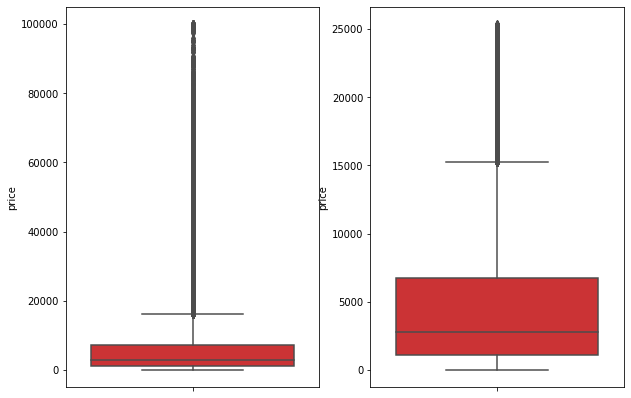

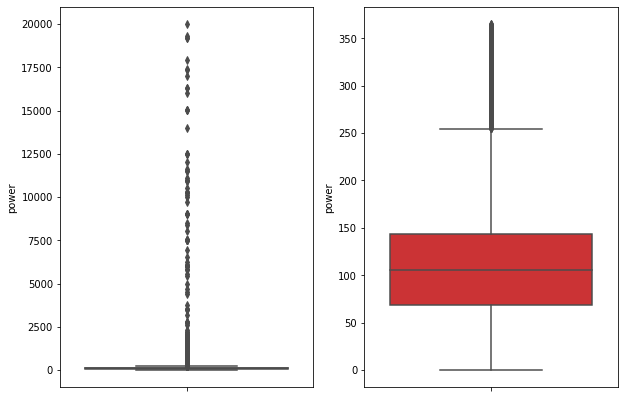

In [6]:
traindata = outliers_proc(traindata, 'price', scale=3)
traindata = outliers_proc(traindata, 'power', scale=3)

将训练集和测试集合并，保留训练集标签

In [7]:
traindata['train']=1
testdata['train']=0
data = pd.concat([traindata, testdata], ignore_index=True)

这里计算汽车使用年份。由于日期格式不规范，用日作为单位会产生大量缺失值，月份又有00这样的值，所以这里选择使用年作单位，提取使用年份的特征

In [8]:
data['used_year'] = data['creatDate'].apply(lambda x : str(x)[:4]).astype(int)-data['regDate'].apply(lambda x : str(x)[:4]).astype(int)

查看每一列的缺失值之和

In [9]:
data.isnull().sum()

SaleID                   0
name                     0
regDate                  0
model                    0
brand                    0
bodyType             30321
fuelType             26621
gearbox              16046
power                    0
kilometer                0
notRepairedDamage    57676
regionCode               0
seller                   0
offerType                0
creatDate                0
price                50000
v_0                      0
v_1                      0
v_2                      0
v_3                      0
v_4                      0
v_5                      0
v_6                      0
v_7                      0
v_8                      0
v_9                      0
v_10                     0
v_11                     0
v_12                     0
v_13                     0
v_14                     0
v_15                     0
v_16                     0
v_17                     0
v_18                     0
v_19                     0
v_20                     0
v

可以看出，bodytype,fueltype,gearbox,notRepairedDamage存在大量缺失值，这里选择-1填充，当作未知量，后期可以考虑利用神经网络或者决策树算法估计出bodytype,fueltype,gearbox存在的缺失值。

In [10]:
data=data.fillna(-1)

查看power列特征分布情况

<AxesSubplot:ylabel='Frequency'>

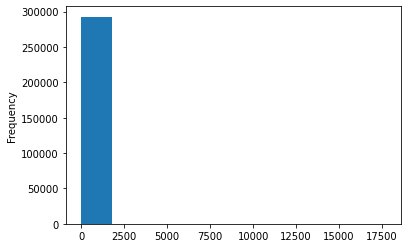

In [11]:
data['power'].plot.hist()

查看训练及特征分布

In [12]:
# 我们对其取 log，在做归一化

<AxesSubplot:ylabel='Frequency'>

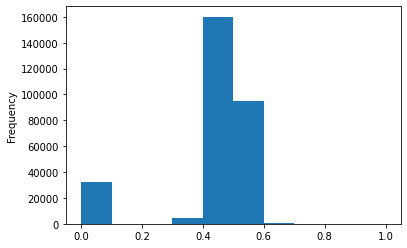

In [13]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
data['power'] = np.log(data['power'] + 1) 
data['power'] = ((data['power'] - np.min(data['power'])) / (np.max(data['power']) - np.min(data['power'])))
data['power'].plot.hist()

查看公里数特征分布，不需要进行操作

<AxesSubplot:ylabel='Frequency'>

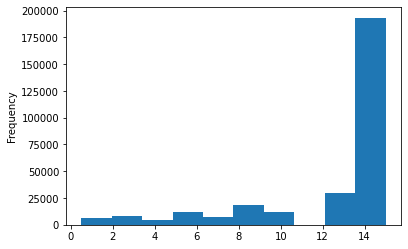

In [14]:
data['kilometer'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

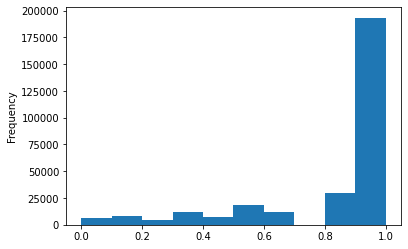

In [15]:
#归一化
data['kilometer'] = ((data['kilometer'] - np.min(data['kilometer'])) / 
                        (np.max(data['kilometer']) - np.min(data['kilometer'])))
data['kilometer'].plot.hist()

 对类别特征进行 OneEncoder，目的是将特征离散化和稀疏化，提高计算速度

In [16]:
data = pd.get_dummies(data, columns=['model', 'brand', 'bodyType', 'fuelType',
                                     'gearbox', 'notRepairedDamage'])

regioncode选择直接*0.0001

In [17]:
data['regionCode']=data['regionCode']*0.0001
data['regionCode']

0         0.0725
1         0.2568
2         0.0724
3         0.0498
4         0.1273
           ...  
292687    0.2676
292688    0.5396
292689    0.6841
292690    0.0181
292691    0.6400
Name: regionCode, Length: 292692, dtype: float64

将匿名特征归一化

In [18]:
for i in range(23):
    col='v_'+str(i)
    data[col]=((data[col] - np.min(data[col])) / 
                        (np.max(data[col]) - np.min(data[col])))

In [19]:
testdata=data[data['train']==0]
testdata

,SaleID,name,regDate,power,kilometer,regionCode,seller,offerType,creatDate,price,...,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_-1.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_-1.0,notRepairedDamage_0.0,notRepairedDamage_1.0
242692,720326,505,20060505,0.461168,0.517241,0.0479,1,0,20160402,-1.0,...,0,0,0,0,0,0,1,0,0,1
242693,714316,1836,20010301,0.442753,1.000000,0.1312,1,0,20160323,-1.0,...,0,1,0,0,0,0,1,0,0,1
242694,704693,212291,20170610,0.512942,1.000000,0.4187,1,0,20160322,-1.0,...,0,0,1,0,0,1,0,0,1,0
242695,624972,1345,19820005,0.000000,0.379310,0.7023,1,0,20160309,-1.0,...,0,0,0,0,0,0,1,0,1,0
242696,669753,1428,20060205,0.491974,1.000000,0.5977,1,0,20160308,-1.0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292687,375033,3803,20010407,0.534803,0.655172,0.2676,1,0,20160329,-1.0,...,0,0,0,0,0,1,0,0,0,1
292688,406556,28500,20071001,0.573485,0.448276,0.5396,1,0,20160322,-1.0,...,0,0,0,0,0,1,0,0,0,1
292689,511668,98383,19980102,0.536967,0.000000,0.6841,1,0,20160316,-1.0,...,0,0,0,0,0,0,1,0,0,1
292690,533139,1489,20031001,0.472835,1.000000,0.0181,1,0,20160402,-1.0,...,0,1,0,0,1,0,0,0,0,1


In [20]:
traindata=data[data['train']==1]
traindata

,SaleID,name,regDate,power,kilometer,regionCode,seller,offerType,creatDate,price,...,fuelType_3.0,fuelType_4.0,fuelType_5.0,fuelType_6.0,gearbox_-1.0,gearbox_0.0,gearbox_1.0,notRepairedDamage_-1.0,notRepairedDamage_0.0,notRepairedDamage_1.0
0,134890,734,20160002,0.000000,1.000000,0.0725,1,0,20160316,520.0,...,0,0,0,0,0,0,1,1,0,0
1,306648,196973,20080307,0.527437,1.000000,0.2568,1,0,20160311,5500.0,...,0,0,1,0,0,0,1,0,0,1
2,340675,25347,20020312,0.401971,0.827586,0.0724,1,0,20160323,1100.0,...,0,0,0,0,0,0,1,0,0,1
3,57332,5382,20000611,0.409690,1.000000,0.0498,1,0,20160330,1200.0,...,0,0,0,0,0,0,1,0,0,1
4,265235,173174,20030109,0.499194,0.172414,0.1273,1,0,20160307,3300.0,...,0,0,1,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242687,19766,16664,20100203,0.512942,0.586207,0.3963,1,0,20160319,9900.0,...,0,0,1,0,0,0,1,0,0,1
242688,10556,9332,20170003,0.416867,1.000000,0.0252,1,0,20160331,1200.0,...,0,0,0,0,0,0,1,0,0,1
242689,146710,102110,20030511,0.421938,1.000000,0.2380,1,0,20160401,1200.0,...,0,0,0,0,0,1,0,0,0,1
242690,116066,82802,20130312,0.491974,0.172414,0.5599,1,0,20160322,16500.0,...,0,0,0,0,0,0,1,0,0,1


In [ ]:
numerical_cols = traindata.select_dtypes(exclude='object').columns
feature_cols = [col for col in numerical_cols if
                col not in ['SaleID', 'name', 'price', 'creatDate', 'regDate']]
feature_cols

In [ ]:
carnmi=[]
for col in feature_cols:
    result_nmi=metrics.normalized_mutual_info_score(traindata[col], traindata['price'])
    carnmi.append(result_nmi)
feature_cols=list(feature_cols)
hhh={'feature_cols':feature_cols,'carnmi':carnmi}
gugug=pd.DataFrame(hhh)

将特征提取后的训练集和测试集保存

In [21]:
# testdata.to_csv('deal_test.csv')
# traindata.to_csv('deal_train.csv')

# 3.3 总结